## Notebook: Generating SLSN Light Curves based on ZTF Raw Data

This notebook shows how to: <br />
1) Load raw ZTF data into the `simsurvey` <br />
2) Feed the SLSN lightcurves generated using the `Magnetar Model` to the transient generator <br />
3) Generate the simulated SLSN light curves which can be detected by the ZTF Survey. <br />
4) Filters the simulated light curves with cutoffs like `|b| > 10` and `sum(rmag < 19.5) >= 3`  <br />
5) Plots the detection phase distribution and the redshift distribution of the SLSNe


In [1]:
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx #
# xxxxxxxxxxxxxxxxxxxxxxx-----------------Generating SLSN Light Curves----------------------xxxxxxxxxxxxxxxxxxxxxxxxx #
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx #

# ------------------------------------------------------------------------------------------------------------------- #
# Import Modules
# ------------------------------------------------------------------------------------------------------------------- #
import os
import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.ticker import MultipleLocator

import sncosmo
import simsurvey
from astropy.time import Time
from astropy import units as u
from astropy.cosmology import Planck15
from astropy.coordinates import SkyCoord
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Initialize Globals
# ------------------------------------------------------------------------------------------------------------------- #
gallat_cutoff = 10
mag_band = 'ztfr'
mag_cutoff = 19.5
npoints = 4

dict_bands = {'ztfg': [4087, 4722.7, 5522], 'ztfr': [5600, 6339.6, 7317], 'desi': [7317, 7886.1, 8884]}
dict_rlambda = {'ztfg': 3.694, 'ztfr': 2.425, 'desi': 1.718}

time_start = time.time()
cm = cm.get_cmap('jet')
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Initialize Directories
# ------------------------------------------------------------------------------------------------------------------- #
os.environ["HOME"] = "/data/asingh/simsurvey"
DIR_HOME = os.environ.get("HOME")

# Directory containing the data files
DIR_DATA = "/data/cfremling/simsurvey"
# Directory containing the dust map files of Schlegel, Finkbeiner & Davis (1998)
DIR_SFD = os.path.join(DIR_HOME, "data/sfd98")

# Enter the name of the 'ztf_sim' output file you would like to use.
survey_file = os.path.join(DIR_DATA, "notebooks/df_sim_stats_full.p")
survey_fields = os.path.join(DIR_HOME, "data/ZTF_Fields.txt")
survey_ccds = os.path.join(DIR_HOME, "data/ZTF_corners.txt")

# Enter the name of the template light curve
template_file = os.path.join(DIR_HOME, "data/PTF12dam.dat")
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Load ZTF Fields, CCD Corners and Filters
# ------------------------------------------------------------------------------------------------------------------- #
raw_fields = np.genfromtxt(survey_fields, comments='%')
fields = {'field_id': np.array(raw_fields[:,0], dtype=int), 'ra': raw_fields[:,1], 'dec': raw_fields[:,2]}
fields_df = pd.DataFrame(fields)

ccd_corners = np.genfromtxt(survey_ccds, skip_header=1)
ccds = [ccd_corners[4 * k:4 * k + 4, :2] for k in range(16)]

bands = {'ztfr' : 'data/ztfr_eff.txt', 'ztfg' : 'data/ztfg_eff.txt'}
for band in bands.keys() :
        filename = os.path.join(DIR_HOME, bands[band])
        bpass = np.loadtxt(filename)
        bandname = sncosmo.Bandpass(bpass[:,0], bpass[:,1], name=band)
        sncosmo.registry.register(bandname, force=True)
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Helper Functions
# ------------------------------------------------------------------------------------------------------------------- #

def abmag_to_flambda(abmag, band):
    return 2.99792e18 * (10 ** (-0.4 * (abmag + 48.6)))/(dict_bands[band][1] ** 2)
    

def z_to_distmod(z):
    distance = Planck15.luminosity_distance(z).value
    return 5 * np.log10(distance * 1e6) - 5
# ------------------------------------------------------------------------------------------------------------------- #


### Load the ZTF Input Data into the Survey Plan
1) Read the raw ZTF Input Data <br />
2) Modify the data in order to be fed to `simsurvey` <br />
3) Load the modified data into the `SurveyPlan

In [2]:
# ------------------------------------------------------------------------------------------------------------------- #
# Read the Raw ZTF Input Data
# ------------------------------------------------------------------------------------------------------------------- #

def mod_rawdata(inp_df):
    """
    Modify the input Pandas DataFrame to be passed to the SimSurvey.
    Args:
    inp_df   : Input DataFrame to be modified
    Returns:
    out_df   : Output DataFrame with relevant modifications
    """
    band_dict = {1: 'ztfg', 2: 'ztfr', 3: 'desi'}
    survey_start = Time("2018-03-17 00:00:00.000").jd
    survey_end = Time("2019-12-31 00:00:00.000").jd
    
    out_df = inp_df.copy()
    out_df['filterid'] = out_df['filterid'].apply(lambda band: band_dict[band])
    out_df['skynoise'] = [(10 ** (-0.4 * (limmag - 30))) / 5. for limmag in out_df['limMag']]
    out_df = out_df[~out_df['fieldid'].isin([880, 881])]                           # For using only main grid data
    out_df = out_df[(out_df['jd'] > survey_start) & (out_df['jd'] < survey_end)]

    print ("Survey pointings for All ZTF Programs: {0}".format(len(out_df)))
    print ("Survey pointings for MSIP Programs: {0}".format(len(out_df[out_df['progid'] == 1])))

    return out_df


raw_df = pd.read_pickle(os.path.join(DIR_DATA, survey_file))
raw_df = mod_rawdata(raw_df)
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Load the Modified ZTF data into the Survey Plan
# ------------------------------------------------------------------------------------------------------------------- #
plan = simsurvey.SurveyPlan(time=raw_df['jd'], band=raw_df['filterid'], obs_field=raw_df['fieldid'], 
                            skynoise=raw_df['skynoise'], obs_ccd=raw_df['chid'], comment=raw_df['progid'],
                            ccds=ccds, fields={k: v for k, v in fields.items()
                                                if k in ['ra', 'dec', 'field_id', 'width', 'height']})

mjd_range = (plan.cadence['time'].min() - 30, plan.cadence['time'].max() + 30)
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Review the pointing schedule, you can use this table
# ------------------------------------------------------------------------------------------------------------------- #
# print (type(plan.pointings), len(plan.pointings))
# plan.pointings
# ------------------------------------------------------------------------------------------------------------------- #

Survey pointings for All ZTF Programs: 5337921
Survey pointings for MSIP Programs: 5337921


### Input to the Transient Generator
1) It combines a model and a distribution representing the transient population, and randomly draws all the parameters needed to simulate the lightcurves. <br />
2) The maximum redshift has been kept as 0.4, beyond which detectability of SLSN is most likely improbable from ZTF.

In [3]:
# ------------------------------------------------------------------------------------------------------------------- #
# Input the Observed Photometric Template to the Transient Generator
# ------------------------------------------------------------------------------------------------------------------- #

dict_defaults = {'type': 'SLSN', 'z': (0.0, 0.2), 'data_file': survey_file, 'rate': 2.5e-7}


def make_source(input_lc):
    """
    Make a TimeSeriesSource of the observed photometric template assuming a certain SED shape.
    Args:
        input_lc   : Input light curve template to be used as input to the simulation
    Returns:
        model      : A sncosmo.Source that specifies a spectral timeseries of the template
    """
    def get_waverange(band):
        limits = dict_bands[band]
        if band == 'ztfg':
            waverange = np.arange(limits[0] - 1500, limits[-1], 10)
        elif band == 'ztfr':
            waverange = np.arange(limits[0], limits[-1], 10)
        elif band == 'desi':
            waverange = np.arange(limits[0], limits[-1] + 2000, 10)
        return waverange

    dist_mag = z_to_distmod(0.107)
    
    lc = pd.read_csv(input_lc, sep='\s+', comment='#')
    lc['flux_g'] = lc['M_g'].apply(lambda x: abmag_to_flambda(x + dist_mag, 'ztfg'))
    lc['flux_r'] = lc['M_r'].apply(lambda x: abmag_to_flambda(x + dist_mag, 'ztfr'))
    lc['flux_i'] = lc['M_i'].apply(lambda x: abmag_to_flambda(x + dist_mag, 'desi'))
    
    norm_factor = lc['flux_r'].max()
    lc[['flux_g', 'flux_r', 'flux_i']] /= norm_factor
    
    phase = lc['Phase'].values
    masterwave = np.array([val for band in dict_bands.keys() for val in get_waverange(band)])
    
    masterflux = []
    for epoch in phase:
        temp = lc.loc[lc['Phase'] == epoch]
        tempflux = []
        for band, limits in dict_bands.items():
            wave = get_waverange(band)
            tempflux.extend([temp['flux_' + band[-1]].values[0]] * len(wave))
        masterflux.append(tempflux)

    masterflux = np.array(masterflux)
    print (phase.shape, masterwave.shape, masterflux.shape)

    dust = sncosmo.CCM89Dust()
    source = sncosmo.TimeSeriesSource(name='SLSN', phase=phase, wave=masterwave, flux=masterflux, zero_before=True)
    model = sncosmo.Model(source=source, effects=[dust], effect_names=['host'], effect_frames=['rest'])
    
    return model

model = make_source(template_file)
# OUTPUT: model.param_names = ['z', 't0', 'amplitude', 'hostebv', 'hostr_v', 'mwebv', 'mwr_v']

def random_parameters(redshifts, r_v=3.1, mag=(-21.642, 1), ebv_rate=0.11, cosmo=Planck15, **kwargs):
    out = {}
    amp = []
    print ("Number of Redshift Bins: {0}".format(len(redshifts)))

    for z in redshifts:
        mabs = np.random.normal(mag[0], mag[1])
        model.set(z=z)
        model.set_source_peakabsmag(absmag=mabs, band='ztfr', magsys='ab', cosmo=cosmo)
        amp.append(model.get('amplitude'))
      
    out['amplitude'] = np.array(amp)

    return out

tr = simsurvey.get_transient_generator(zrange=dict_defaults['z'],
                                       ratefunc=lambda z: dict_defaults['rate'],
                                       dec_range=(-31, 90),
                                       mjd_range=(mjd_range[0], mjd_range[1]),
                                       sfd98_dir=DIR_SFD,
                                       transientprop={'lcmodel': model, 'lcsimul_func': random_parameters})
# ------------------------------------------------------------------------------------------------------------------- #


(203,) (823,) (203, 823)
Number of Redshift Bins: 699


### Simulate Survey and save the generated Light Curves
Generate light curves using the transient generator and the survey plan as inputs

In [4]:
# ------------------------------------------------------------------------------------------------------------------- #
# Generate The Light Curves
# ------------------------------------------------------------------------------------------------------------------- #
survey = simsurvey.SimulSurvey(generator=tr, plan=plan)
lcs = survey.get_lightcurves(progress_bar=True, notebook=True)
#, notebook=True # If you get an error because of the progress_bar, delete this line.)
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Check the Generated Light Curves and Save Them
# ------------------------------------------------------------------------------------------------------------------- #
lcs.save('LCS_SLSN_MasterV3.pkl')

print("Time Taken to Run the Simulation = {0:.2f} seconds".format(time.time() - time_start))
# ------------------------------------------------------------------------------------------------------------------- #

Determining field IDs for all objects


FloatProgress(value=0.0)


Generating lightcurves


FloatProgress(value=0.0)


Time Taken to Run the Simulation = 119.22 seconds


### Filtering the Simulated Light Curve Data

In [5]:
# ------------------------------------------------------------------------------------------------------------------- #
# Read the Light Curves from the Pickle File
# Filter the Simulated Light Curves Data 
# ------------------------------------------------------------------------------------------------------------------- #

def filter_lcdata(inp_data):
    """
    Filter the Simulated Light Curves data from simsurvey using the criterions mentioned below.
    The light curve was filtered with the condition that SNR >= 3. The requirements are:
    1) Atleast 4 detections are brighter the ztfr-band magnitude cutoff of 19.5 mag.
    2) The 4 detections should be separated by atleast 12 hrs.
    3) There are 4 detections before +50 d.
    Args:
    inp_data  : Simulated light curves data from simsurvey
    Returns:
    inp_data  : Filtered light curves data with necessary requirements
    """
    drop_indices = []
    for lc in range(len(inp_data['lcs'])):
        lc_df = pd.DataFrame(data=inp_data['lcs'][lc], columns=inp_data['lcs'][0].dtype.names)
        lc_df['mag'] = -2.5 * np.log10(lc_df['flux']) + lc_df['zp']
        lc_df['phase'] = lc_df['time'] - inp_data['meta']['t0'][lc]
        lc_df['snr'] = lc_df['flux'] / lc_df['fluxerr']
        
        # Keep the LC points that have an SNR greater than 3 (Essential for filtering)
        lc_df = lc_df[lc_df['snr'] >= 3]

        temp_df = lc_df.loc[(lc_df['band'] == mag_band) & (lc_df['mag'] <= mag_cutoff)]

        # Check for LCs that adhere to the Apparent Magnitude cutoff
        if temp_df.shape[0] < npoints:
            drop_indices.append(lc)
            continue

        # Check whether a minimum of 4 detections above the cutoff are separated by atleast 12 hrs.
        else:
            time_diff = np.diff(temp_df['time'].values)
            points_diff = len([val for val in time_diff if abs(val) >= 0.5])
            if points_diff < npoints - 1:
                drop_indices.append(lc)
                continue
                
            # Check whether there are few detections before +50 d
            else:
                if temp_df[temp_df['phase'] <= 50].shape[0] < npoints:
                    drop_indices.append(lc)
                    continue

        # Check for LCs that do not adhere to Galactic Latitude cutoff
        ra, dec = inp_data['meta']['ra'][lc], inp_data['meta']['dec'][lc]
        coord = SkyCoord(ra=ra * u.degree, dec=dec * u.degree, frame='icrs')
        if abs(coord.galactic.b.degree) < gallat_cutoff:
            drop_indices.append(lc)
            
    out_data = inp_data.copy()
    for val in sorted(drop_indices, reverse=True):
        del(out_data['lcs'][val])
    for key in [x for x in out_data.keys() if x in['meta', 'stats']]:
        for val in out_data[key].keys():
            if not val in ['p_binned', 'mag_max']:
                out_data[key][val] = np.delete(out_data[key][val], drop_indices, 0)
            else:
                for subkey in out_data[key][val].keys():
                    out_data[key][val][subkey] = np.delete(out_data[key][val][subkey], drop_indices, 0)

    return out_data

data_raw = pickle.load(open('LCS_SLSN_MasterV3.pkl', 'rb'))
lcs_raw = simsurvey.LightcurveCollection(load='LCS_SLSN_MasterV3.pkl')
print ("Number of Light Curves in Raw Data: {0}".format(len(lcs_raw.lcs)))

data_mod = filter_lcdata(data_raw)
pickle.dump(data_mod, open('LCS_SLSN_FilteredV3.pkl', 'wb'))
lcs = simsurvey.LightcurveCollection(load='LCS_SLSN_FilteredV3.pkl')
print ("Number of Light Curves in Filtered Data: {0}".format(len(lcs.lcs)))
# ------------------------------------------------------------------------------------------------------------------- #


Number of Light Curves in Raw Data: 481


/data/lyan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log10


Number of Light Curves in Filtered Data: 276


In [6]:
# lcs[0].meta
# print (data_mod['meta'].keys())
# print (len(data_mod['lcs']), len(data_mod['meta']['t0']))
# print (data_mod['stats']['p_det'])
# print (data_mod['stats']['p_last'])
# print (len(np.sort(data_mod['stats']['p_last'] - data_mod['stats']['p_det'])))

In [7]:
# ------------------------------------------------------------------------------------------------------------------- #
# Functions to help with Plotting
# ------------------------------------------------------------------------------------------------------------------- #

def set_plotparams(ax_obj, xticks=(100, 20), yticks=(1, 0.1), fs=14):
    """
    Sets plot parameters for plotting Simulated Light Curves.
    """
    ax_obj.grid(True, which='major', ls='--', lw=1)
    ax_obj.xaxis.set_ticks_position('both')
    ax_obj.yaxis.set_ticks_position('both')
    ax_obj.xaxis.set_major_locator(MultipleLocator(xticks[0]))
    ax_obj.xaxis.set_minor_locator(MultipleLocator(xticks[1]))
    ax_obj.yaxis.set_major_locator(MultipleLocator(yticks[0]))
    ax_obj.yaxis.set_minor_locator(MultipleLocator(yticks[1]))
    ax_obj.tick_params(axis='both', which='major', direction='in', width=1.6, length=9, labelsize=fs)
    ax_obj.tick_params(axis='both', which='minor', direction='in', width=1.0, length=5, labelsize=fs)

    
def set_plotsingle(lc, band, ax_obj1, ax_obj2, corr, data=data_mod):
    """
    Sets plot parameters for plotting individual Simulated Light Curve.
    """
    appmin = df['mag'].max()
    appmax = df['mag'].min()

    ax_obj1.set_ylim(appmin + 0.5, appmax - 0.5)
    ax_obj2.set_ylim(appmin - corr + 0.5, appmax - corr - 0.5)
    
    ep_det = data['stats']['p_det'][lc]
    ep_last = data['stats']['p_last'][lc]
    mag_max = data['stats']['mag_max'][band][lc]

    ax_obj1.axvline(0, ls='-', lw=2, color='k')
    ax_obj2.axvline(0, ls='-', lw=2, color='k')
    ax_obj1.axvline(ep_det, ls='-', lw=2, color='orangered')
    ax_obj2.axvline(ep_det, ls='-', lw=2, color='orangered')
    ax_obj1.axvline(ep_last, ls='-', lw=2, color='orangered')
    ax_obj2.axvline(ep_last, ls='-', lw=2, color='orangered')
    ax_obj1.axhline(appmax, ls='-', lw=2, color='k')
    ax_obj2.axhline(appmax - corr, ls='-', lw=2, color='k')
    
    ax_obj1.text(-11, appmax + 0.5, 'Explosion Epoch', fontsize=10, rotation=90)
    ax_obj2.text(-11, appmax - corr + 0.5, 'Explosion Epoch', fontsize=10, rotation=90)
    ax_obj1.text(ep_det - 11, appmax + 0.5, 'Detection Epoch', fontsize=10, rotation=90)
    ax_obj2.text(ep_det - 11, appmax - corr + 0.5, 'Detection Epoch', fontsize=10, rotation=90)
    ax_obj1.text(ep_last - 11, appmax + 0.5, 'Last Epoch', fontsize=10, rotation=90)
    ax_obj2.text(ep_last - 11, appmax - corr + 0.5, 'Last Epoch', fontsize=10, rotation=90)
    ax_obj1.text(100, appmax - 0.05, 'Maximum Magnitude', fontsize=10)
    ax_obj2.text(100, appmax - corr - 0.05, 'Maximum Magnitude', fontsize=10)


def plot_lcs(ax, df, lc, band, alpha=0.5, data=data_mod, single=False):
    """
    Plots the Simulated Light Curves in a 2 x 3 Grid with 2 rows depicting the Apparent 
    and the Absolute Light Curves, respectively whereas the 3 columns depict the different 
    ZTF filters.
    """
    if band == 'ztfg':
        index = 0
        color = 'g'
    elif band == 'ztfr':
        index = 1
        color = 'r'
    elif band == 'desi':
        index =  2
        color = 'blue'

    ax_obj1 = ax[0][index]
    ax_obj2 = ax[1][index]

    zlc = data['meta']['z'][lc]
    distlc = Planck15.luminosity_distance(zlc).value
    distmag = 5 * np.log10(distlc * 1e6) - 5
    corr = distmag + data['meta']['mwebv_sfd98'][lc] * dict_rlambda[band] - 2.5 * np.log10((1 + zlc))
    
    ax_obj1.errorbar(df['phase'], df['mag'], yerr=df['magerr'], ms=8, alpha=alpha,
                    color='dimgrey', markerfacecolor=color, markeredgewidth=0.5, marker='o', ls='-', 
                     capthick=1, elinewidth=1, capsize=2, zorder=1, label='_nolegend_')
    ax_obj2.errorbar(df['time'] / (1 + zlc), df['mag'] - corr, yerr=df['magerr'], ms=8, 
                     alpha=alpha, color='dimgrey', marker='o', markerfacecolor=color, markeredgewidth=0.5, 
                     ls='', capthick=1, elinewidth=1, capsize=2, zorder=1, label='_nolegend_')
    
    if single:
        set_plotsingle(lc, band, ax_obj1, ax_obj2, corr=corr, data=data)
    else:
        ax_obj1.set_ylim(22.8, 12.6)
        ax_obj2.set_ylim(-14.8, -25.3)

    set_plotparams(ax_obj1)
    set_plotparams(ax_obj2)
    ax_obj1.set_xlim(-110, 370)
    ax_obj1.set_title(band, color=color, fontsize=16)
    ax_obj2.set_xlabel('Phase [In Days]', fontsize=16)    
# ------------------------------------------------------------------------------------------------------------------- #


### PLOT - Summation of Simulated Light Curves

/data/lyan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


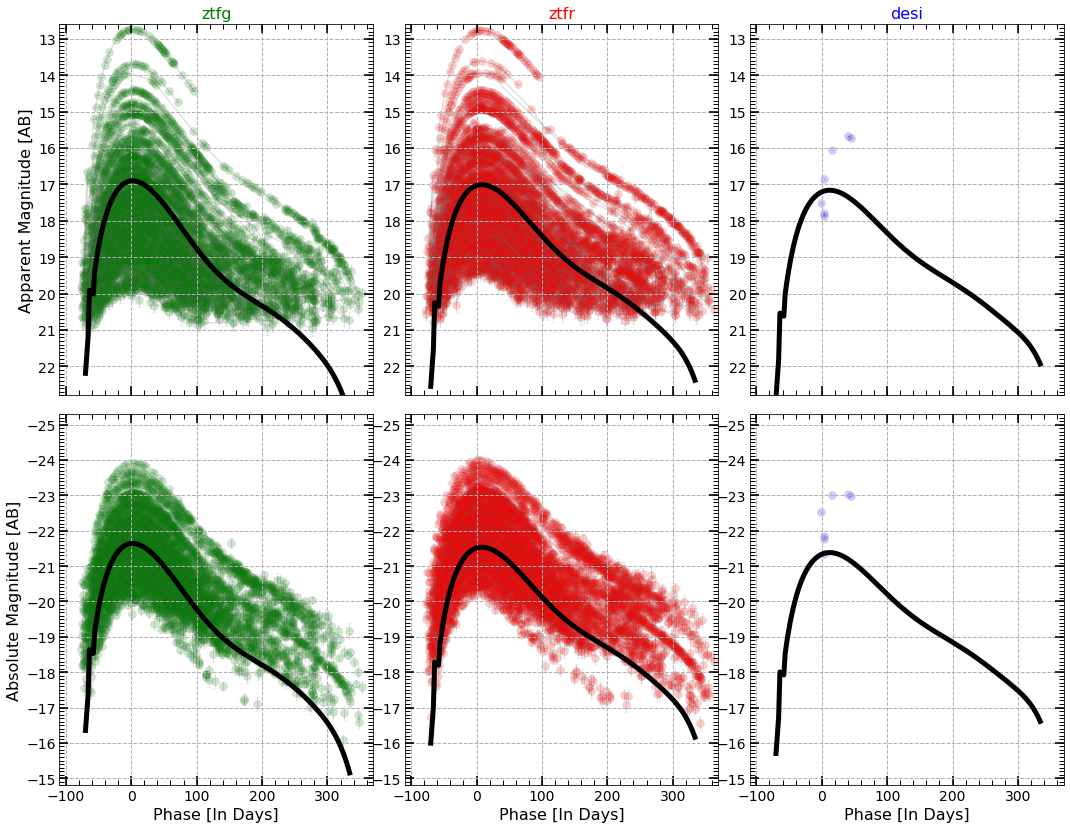

In [8]:
# ------------------------------------------------------------------------------------------------------------------- #
# Plot the Combined Results of the Simulated Light Curves
# ------------------------------------------------------------------------------------------------------------------- #
fig, ax = plt.subplots(2, 3, sharex=True, figsize=(18, 14))

for lc in range(len(data_mod['lcs'])):
    lc_df = pd.DataFrame(data=data_mod['lcs'][lc], columns=data_mod['lcs'][0].dtype.names)
    lc_df['mag'] = -2.5 * np.log10(lc_df['flux']) + lc_df['zp']
    lc_df['magerr'] = -(2.5 / np.log(10)) * (lc_df['fluxerr'] / lc_df['flux'])
    lc_df['phase'] = lc_df['time'] - data_mod['meta']['t0'][lc]
    lc_df['snr'] = lc_df['flux'] / lc_df['fluxerr']
    lc_df = lc_df[lc_df['snr'] >= 3]
    
    for band, df in lc_df.groupby('band'):
        plot_lcs(ax, df, lc, band, alpha=0.2)

ptf12 = pd.read_csv(template_file, sep='\s+', comment='#')
dist_mag = z_to_distmod(0.107)

ax[0][0].plot(ptf12['Phase'], ptf12['M_g'] + dist_mag, marker='', lw=5, ls='-', color='k', zorder=2, label='PTF12dam')
ax[0][1].plot(ptf12['Phase'], ptf12['M_r'] + dist_mag, marker='', lw=5, ls='-', color='k', zorder=2, label='PTF12dam')
ax[0][2].plot(ptf12['Phase'], ptf12['M_i'] + dist_mag, marker='', lw=5, ls='-', color='k', zorder=2, label='PTF12dam')
ax[1][0].plot(ptf12['Phase'], ptf12['M_g'], marker='', lw=5, ls='-', color='k', zorder=2, label='PTF12dam')
ax[1][1].plot(ptf12['Phase'], ptf12['M_r'], marker='', lw=5, ls='-', color='k', zorder=2, label='PTF12dam')
ax[1][2].plot(ptf12['Phase'], ptf12['M_i'], marker='', lw=5, ls='-', color='k', zorder=2, label='PTF12dam')

ax[0][0].set_ylabel('Apparent Magnitude [AB]', fontsize=16)
ax[1][0].set_ylabel('Absolute Magnitude [AB]', fontsize=16)

fig.subplots_adjust(hspace=0.05, wspace=0.10)
fig.savefig('PLOT_LCS_Template', format='pdf', dpi=2000, bbox_inches='tight')

plt.show()
plt.close(fig)
# ------------------------------------------------------------------------------------------------------------------- #

### PLOT - Single Simulated Light Curve [Specify Index]

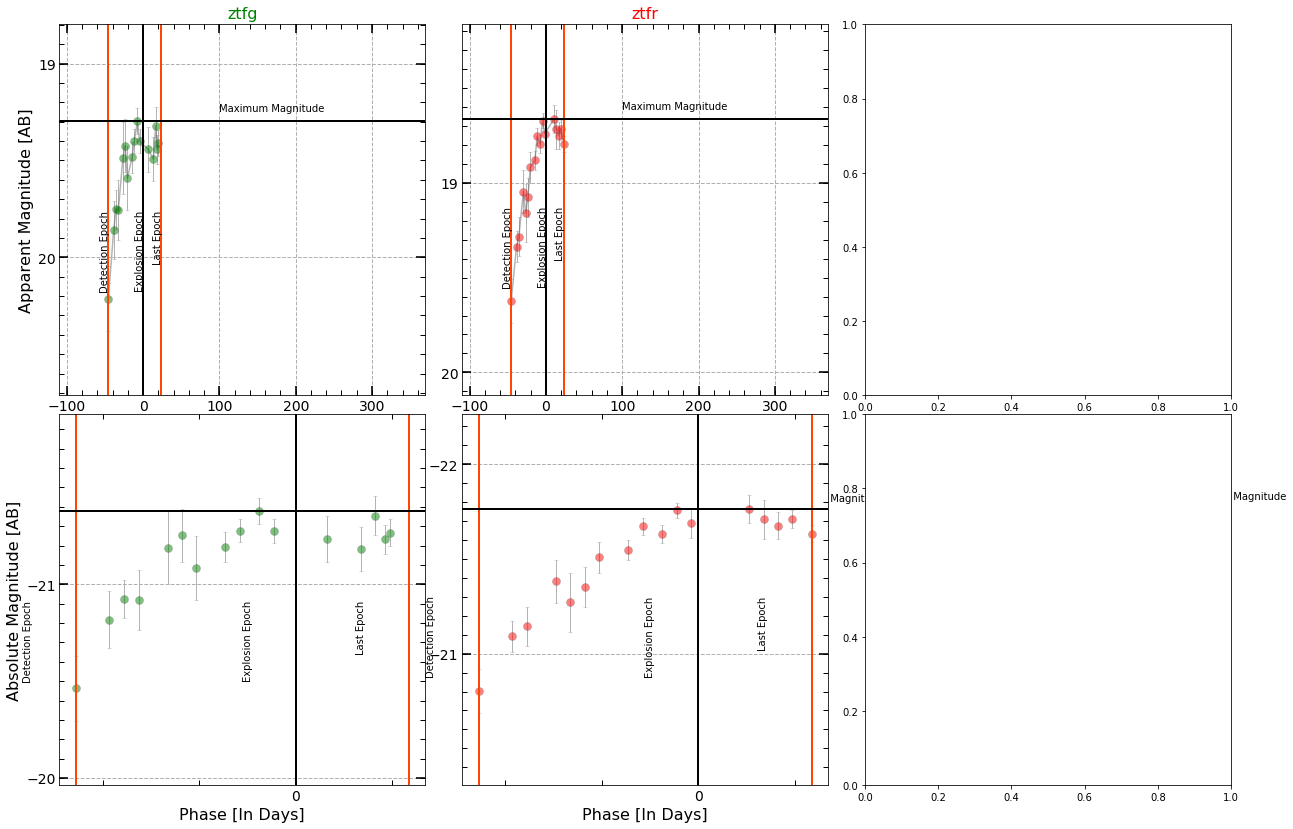

In [9]:
# ------------------------------------------------------------------------------------------------------------------- #
# Plot a single Light Curve from the Simulation (specify Index)
# ------------------------------------------------------------------------------------------------------------------- #
idx = 0

fig2, ax2 = plt.subplots(2, 3, figsize=(21, 14))

lc_df = pd.DataFrame(data=data_mod['lcs'][idx], columns=data_mod['lcs'][idx].dtype.names)
lc_df['mag'] = -2.5 * np.log10(lc_df['flux']) + lc_df['zp']
lc_df['magerr'] = -(2.5 / np.log(10)) * (lc_df['fluxerr'] / lc_df['flux'])
lc_df['snr'] = lc_df['flux'] / lc_df['fluxerr']
lc_df = lc_df[(lc_df['snr'] >= 5)]

for band, df in lc_df.groupby('band'):
    plot_lcs(ax2, df, idx, band, single=True)

ax2[0][0].set_ylabel('Apparent Magnitude [AB]', fontsize=16)
ax2[1][0].set_ylabel('Absolute Magnitude [AB]', fontsize=16)

fig2.subplots_adjust(hspace=0.05, wspace=0.10)
fig2.savefig('PLOT_LC_{0}.pdf'.format(idx), format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig2)
# ------------------------------------------------------------------------------------------------------------------- #

### PLOT - Detection Phase Distribution of Simulated Light Curves

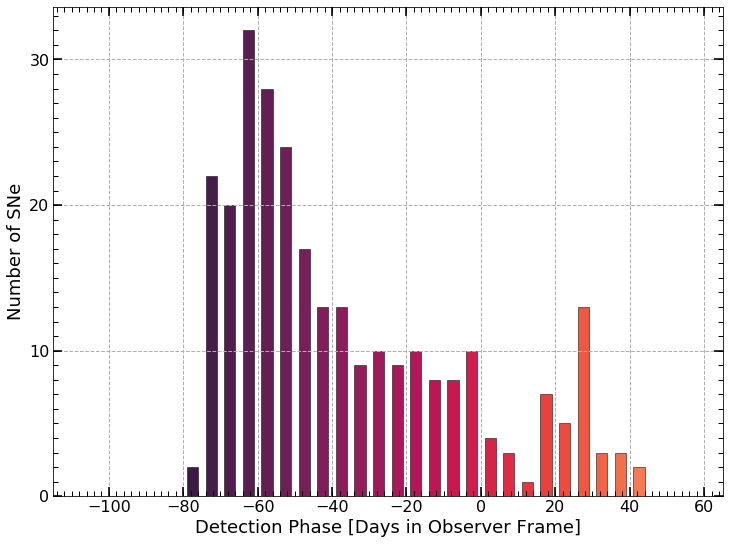

In [10]:
# ------------------------------------------------------------------------------------------------------------------- #
# Plots the Detection Phase Distribution
# ------------------------------------------------------------------------------------------------------------------- #

fig3 = plt.figure(figsize=(12, 9))
ax3 = fig3.add_subplot(111)

heights, bins = np.histogram(lcs.stats['p_det'], range=(-110, 60), bins=34)
centers = (bins[:-1] + bins[1:]) / 2

ax3.bar(centers, heights, width=3, ec='k', lw=0.5, color=sns.color_palette('rocket', int(len(bins) * 1.2)))
# ax3.hist(lcs.stats['p_det'], histtype='bar', rwidth=0.75, color='dimgrey', range=(-10, 120), bins=32)

ax3.set_xlim(-115, 65)
set_plotparams(ax3, xticks=(20, 2), yticks=(10, 1), fs=16)

ax3.set_xlabel('Detection Phase [Days in Observer Frame]', fontsize=18)
ax3.set_ylabel('Number of SNe', fontsize=18)

fig3.savefig('PLOT_DPD_Template.pdf', format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig3)
# ------------------------------------------------------------------------------------------------------------------- #

### PLOT - Redshift Distribution of Simulated Light Curves

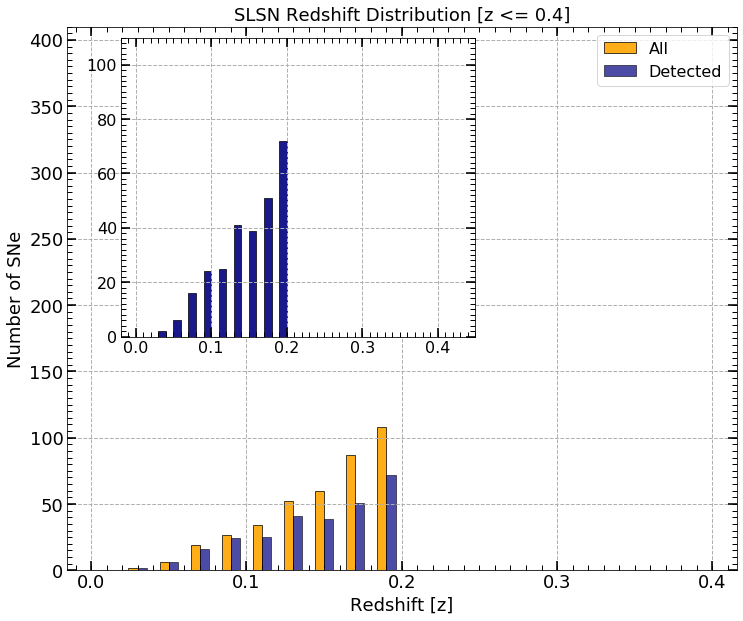

In [11]:
# ------------------------------------------------------------------------------------------------------------------- #
# Plots the Redshift Distribution
# ------------------------------------------------------------------------------------------------------------------- #
fig4 = plt.figure(figsize=(12, 10))
ax4 = fig4.add_subplot(111)

zhsfull, zbinsfull = np.histogram(lcs.meta_full['z'], range=(0, 0.4), bins=20)
zcentersfull = (zbinsfull[:-1] + zbinsfull[1:]) / 2
zhs, zbins = np.histogram(lcs.meta['z'], range=(0, 0.4), bins=20)
zcenters = (zbins[:-1] + zbins[1:]) / 2

ax4.bar(zcentersfull - 0.003, zhsfull, width=0.006, alpha=0.9, ec='k', lw=0.8, color='orange', label='All')
ax4.bar(zcenters + 0.003, zhs, width=0.006, alpha=0.7, ec='k', lw=0.8, color='navy', label='Detected')
# ax4.hist(lcs.meta_full['z'], lw=2, ls='-', histtype='step', color='orangered', range=(0,0.05), bins=25, label='All')
# ax4.hist(lcs.meta['z'], lw=2, ls='-', histtype='step', color='navy', range=(0, 0.05), bins=25, label='Detected')

ax4.set_ylim(0, 410)
ax4.legend(fontsize=16, loc=1)
set_plotparams(ax4, xticks=(0.1, 0.01), yticks=(50, 5), fs=18)
# ax4.set_xticklabels(['' if float(label) < 0 else round(label, 1) for label in ax2.get_xticks()])

ax4.set_xlabel('Redshift [z]', fontsize=18)
ax4.set_ylabel('Number of SNe', fontsize=18)
ax4.set_title('SLSN Redshift Distribution [z <= 0.4]', fontsize=18)

axins = ax4.inset_axes([0.08, 0.43, 0.53, 0.55])
# ax4.indicate_inset_zoom(axins)

# axins.bar(zcentersfull - 0.005, zhsfull, width=0.01, alpha=0.9, color='orangered', label='All')
axins.bar(zcenters + 0.005, zhs, width=0.01, alpha=0.9, ec='k', lw=0.8, color='navy', label='Detected')

axins.set_xlim(-0.02, 0.45)
axins.set_ylim(0, 110)
set_plotparams(axins, xticks=(0.1, 0.01), yticks=(20, 2), fs=16)

fig4.savefig('PLOT_RD_Template.pdf', format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig4)
# ------------------------------------------------------------------------------------------------------------------- #


### PLOT - Peak Absolute Magnitude Distribution of Simulated Light Curves

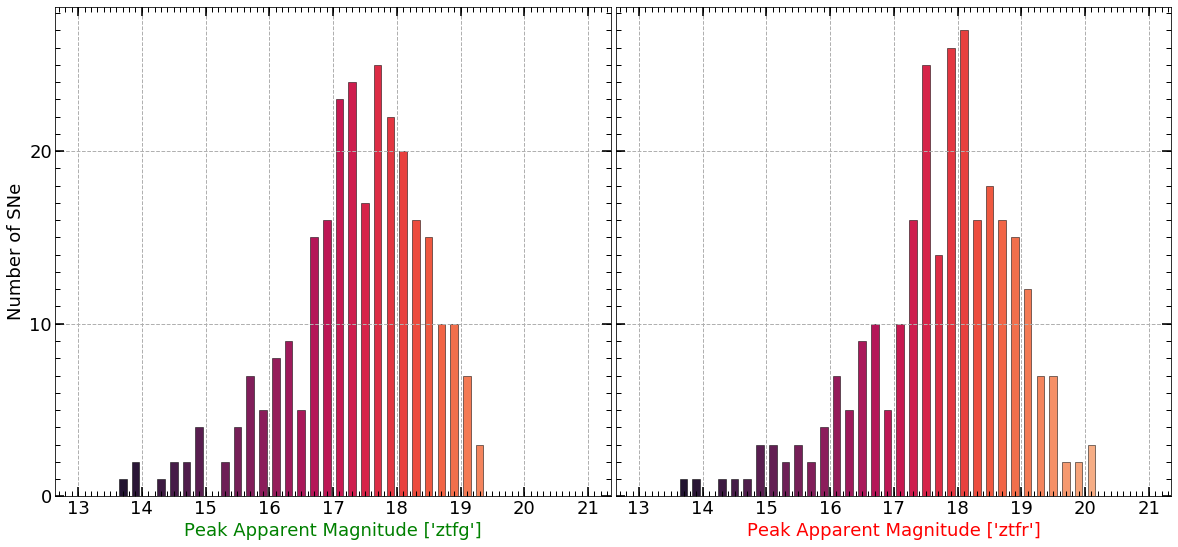

In [12]:
# ------------------------------------------------------------------------------------------------------------------- #
# Plots Peak Absolute Magnitude Distribution
# ------------------------------------------------------------------------------------------------------------------- #
fig5, (ax51, ax52) = plt.subplots(1, 2, sharey=True, figsize=(20, 9))

h_g, bins_g = np.histogram(lcs.stats['mag_max']['ztfg'], range=(13, 21), bins=40)
h_r, bins_r = np.histogram(lcs.stats['mag_max']['ztfr'], range=(13, 21), bins=40)
cen_g = (bins_g[:-1] + bins_g[1:]) / 2
cen_r = (bins_r[:-1] + bins_r[1:]) / 2

ax51.bar(cen_g, h_r, width=0.12, ec='k', lw=0.5, color=sns.color_palette('rocket', int(len(bins) * 1.2)))
ax52.bar(cen_r, h_g, width=0.12, ec='k', lw=0.5, color=sns.color_palette('rocket', int(len(bins) * 1.2)))

set_plotparams(ax51, xticks=(1, 0.1), yticks=(10, 1), fs=18)
set_plotparams(ax52, xticks=(1, 0.1), yticks=(10, 1), fs=18)
ax51.set_xlabel("Peak Apparent Magnitude ['ztfg']", color='g', fontsize=18)
ax52.set_xlabel("Peak Apparent Magnitude ['ztfr']", color='r', fontsize=18)
ax51.set_ylabel('Number of SNe', fontsize=18)

fig5.subplots_adjust(wspace=0.01)
fig5.savefig('PLOT_AppMD_Template.pdf', format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig5)
# ------------------------------------------------------------------------------------------------------------------- #


In [ ]:
# # ------------------------------------------------------------------------------------------------------------------- #
# # Test Code To Find The Faulty ZTF Data
# # ------------------------------------------------------------------------------------------------------------------- #
# raw_df = pd.read_pickle(os.path.join(DIR_DATA, survey_file))
# idx_range = raw_df.index.values
# val_range = np.array_split(idx_range, 1000)

# for val in val_range:
#     try:
#         raw_df = mod_df(pd.read_pickle(os.path.join(DIR_DATA, survey_file)).iloc[val])
#         plan = simsurvey.SurveyPlan(time=raw_df['jd'], band=raw_df['filterid'], obs_field=raw_df['fieldid'], 
#                             skynoise=raw_df['skynoise'], obs_ccd=raw_df['chid'], ccds=ccds, comment=raw_df['progid'], 
#                             fields={k: v for k, v in fields.items() if k in ['ra', 'dec', 'field_id']})
#     except IndexError:
#         print (val)
#         import sys
#         sys.exit(1)
#     else:
#         continue
    
# # ------------------------------------------------------------------------------------------------------------------- #